**Classification Problem on ecommerce using Logistic Regression(58.5% Accuracy),Random Forest(68% accuracy) and XGBoost(68%)**

In [58]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime,date
from time import strptime
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
df = pd.read_csv('BADS_WS2021_known.csv')

In [3]:
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
3,4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
4,5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


In [4]:
#finding total rows and columns
print ("Columns in the dataset: ", df.shape[1])
print ("Rows in the dataset   : ", df.shape[0])

Columns in the dataset:  14
Rows in the dataset   :  100000


#We observe that we have a total of 14 columns.out of these 14, the return column is the target variable, where a value of 1 means that the customer will return an item and 0 means that the customer will not. We have a total of 100,000 rows in the dataset. Let’s see the ratio of values in our target feature:

In [5]:
df['return'].value_counts()

0    54182
1    45818
Name: return, dtype: int64

#lets do the data cleaning, pre-processing, feature engineering and feature selection

In [6]:
#lets see how many unique elements we have for each feature
for col in df.columns:
    print(col,':',len(df[col].unique()),'labels')

order_item_id : 100000 labels
order_date : 82 labels
delivery_date : 124 labels
item_id : 1943 labels
item_size : 102 labels
item_color : 77 labels
brand_id : 135 labels
item_price : 252 labels
user_id : 19205 labels
user_title : 5 labels
user_dob : 9248 labels
user_state : 16 labels
user_reg_date : 573 labels
return : 2 labels


In [7]:
#check for null values
df.isnull().sum()

order_item_id       0
order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
return              0
dtype: int64

In [8]:
#lot of missing rows in delivery_date and user_dob
#we will loose lot of data if we will remove null values so we might have to replace by mean or median but first we have to perform some feature engineering, example : we have to find age from user_dob
#function to convert date to speicif format
from datetime import date
def __datetime(date_str):
    
    #for null values set dob as current date to identify them as their age will be 0
    if date_str!=date_str:
        date_str=str(date.today())

    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting dob with current date and converting to years.
df['Age']=(__datetime(str(date.today()))-df.user_dob.apply(__datetime))/365
df['Age']=df.Age.apply(lambda x: int(str(x).split(" ")[0]) )

In [9]:
df['Age']

0        52
1        52
2        51
3        51
4        51
         ..
99995    62
99996    62
99997    36
99998    36
99999    47
Name: Age, Length: 100000, dtype: int64

In [10]:
#lets try to find the mean or median of each class and replace each null value with this newly calculated value, will use median here
def imputing_age(x,y):
    x0=x[x['return']==1] # subset comprising of return
    x1=x[x['return']==0] # subset comprising of non-return
    x0[y] =x0[y].map( lambda x : x0[y].median() if x == 0 else x) #replacing returns 0s with returns median
    x1[y] =x1[y].map( lambda x : x1[y].median() if x == 0 else x) #replacing non-returns 0s with non-returns median
    return pd.concat([x0,x1])


In [11]:
#Imputing 0 values with median for each class
df=imputing_age(df,'Age')

C:\Users\muskan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\muskan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df['Age'].value_counts()

56.0     8812
55.0     8386
57.0     4630
54.0     4557
59.0     4370
         ... 
23.0        5
15.0        3
22.0        3
91.0        2
118.0       1
Name: Age, Length: 78, dtype: int64

In [13]:
df['Age'].isnull().sum()

0

In [14]:
#drop user_dob since we have age now
df.drop(['user_dob'], axis=1,inplace=True)
df.isna().sum()

order_item_id       0
order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_state          0
user_reg_date       0
return              0
Age                 0
dtype: int64

In [15]:
# We can try to find day, month from delivery date if the order is getting return on any specific day like weekdays
#we can also try to find difference in order_date and delivery_date to find if the delay in delivery could cause the refund
#function to convert date to specific format and to handle null dates
def datetime_delivery(date_str):
    #if date is null set it to 1900-01-01 to identify it and so that difference will be less than 0
    if date_str!=date_str:
        date_str='1900-01-01'

    return datetime.strptime(date_str, '%Y-%m-%d')

def weekday(x):
    #setting null date value to noday for weekday
    if x!=x:
        x='NoDay'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%A')
    return x
def month(x):
    #setting null date value to nomonth for month
    if x!=x:
        x='NoMonth'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%B')
    return x

In [16]:
#differece in order and delivery date
df['Delivery_time']=(df.delivery_date.apply(datetime_delivery)-df.order_date.apply(datetime_delivery))
df['Delivery_time']=df.Delivery_time.apply(lambda x: int(str(x).split(" ")[0]) )
#finding weekday
df['Weekday']=df.delivery_date.apply(weekday)
#finding month
df['Month']=df.delivery_date.apply(month)

In [17]:
#again we can remove the null values from Delivery_time with median, and same for weekday and month which can be easily idetify by negative value from above function
def imputing_delivery(x,y):
    x0=x[x['return']==1] # subset comprising of return
    x1=x[x['return']==0] # subset comprising of non-return
    x0[y] =x0[y].map( lambda x : x0[y].median() if x <= 0 else x) #replacing returns  delivery time less than 0 with returns median
    x1[y] =x1[y].map( lambda x : x1[y].median() if x <= 0 else x) #replacing non-returns delivery time less than 0 with non-returns median
    return pd.concat([x0,x1])

In [18]:
#Imputing 0 values with median for each class
df=imputing_delivery(df,'Delivery_time')

C:\Users\muskan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\muskan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# lets find count of each day with output
df['Weekday'][df['return']==0].value_counts(),df['Weekday'][df['return']==1].value_counts()

(Sunday       11292
 Monday        9443
 Saturday      9368
 NoDay         9318
 Tuesday       7744
 Wednesday     6821
 Thursday       196
 Name: Weekday, dtype: int64,
 Sunday       11736
 Monday        9636
 Saturday      9375
 Tuesday       7763
 Wednesday     7108
 Thursday       200
 Name: Weekday, dtype: int64)

In [20]:
#we will replace null values(noday) with sunday because of highest frequency
df['Weekday']=df['Weekday'].apply(lambda x: x if x!='NoDay' else 'Sunday')
#Now we have replaced all NoDays with sundays
df['Weekday'].value_counts()

Sunday       32346
Monday       19079
Saturday     18743
Tuesday      15507
Wednesday    13929
Thursday       396
Name: Weekday, dtype: int64

In [21]:
df['Month'][df['return']==0].value_counts(),df['Month'][df['return']==1].value_counts()

(August       17843
 July         14648
 NoMonth       9318
 September     6538
 June          3630
 October       1018
 December       718
 November       468
 January          1
 Name: Month, dtype: int64,
 August       19001
 July         13844
 September     6819
 June          4123
 October       1035
 November       559
 December       435
 January          2
 Name: Month, dtype: int64)

In [22]:
#August has the maximum value so will replace null values(nomonth) with August
df['Month']=df['Month'].apply(lambda x: x if x!='NoMonth' else 'August')
#Now we have replaced all NoMonth with August
df['Month'].value_counts()

August       46162
July         28492
September    13357
June          7753
October       2053
December      1153
November      1027
January          3
Name: Month, dtype: int64

In [23]:
#we will convert user_reg_date to number of days user is associated with the retailer
def __datetime_reg(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting registration date by current date to find days with retailer
df['user_reg_days']=(__datetime_reg(str(date.today()))-df.user_reg_date.apply(__datetime_reg))
df['user_reg_days']=df.user_reg_days.apply(lambda x: int(str(x).split(" ")[0]) )
df['user_reg_days'].value_counts()

2400    33966
1903     1325
1901     1064
1902      951
1900      821
        ...  
2274        4
2089        3
2241        2
2090        1
2247        1
Name: user_reg_days, Length: 573, dtype: int64

In [24]:
#lets drop date columns as we have already modified them
df.drop(['order_date','delivery_date','user_reg_date'], axis=1,inplace=True)
df.isna().sum()

order_item_id    0
item_id          0
item_size        0
item_color       0
brand_id         0
item_price       0
user_id          0
user_title       0
user_state       0
return           0
Age              0
Delivery_time    0
Weekday          0
Month            0
user_reg_days    0
dtype: int64

In [25]:
#lets see how many categorical features are there
#getting total columns
cols=df.columns
print("Total Columns in dataset are: ",list(cols))

#getting only numerical columns
numerical_cols=df._get_numeric_data().columns
print("Numerical Columns in dataset are: ",list(numerical_cols))

#getting categorical columns by substracting numerical columns from total columns
categorical_cols=set(list(cols))-set(list(numerical_cols))
print("Categorical Columns in dataset are: ",list(categorical_cols))

Total Columns in dataset are:  ['order_item_id', 'item_id', 'item_size', 'item_color', 'brand_id', 'item_price', 'user_id', 'user_title', 'user_state', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_reg_days']
Numerical Columns in dataset are:  ['order_item_id', 'item_id', 'brand_id', 'item_price', 'user_id', 'return', 'Age', 'Delivery_time', 'user_reg_days']
Categorical Columns in dataset are:  ['item_color', 'user_title', 'Weekday', 'Month', 'item_size', 'user_state']


In [26]:
#lets see how many unique values are there in each feature
for col in df.columns:
    print(col,':',len(df[col].unique()),'labels')

order_item_id : 100000 labels
item_id : 1943 labels
item_size : 102 labels
item_color : 77 labels
brand_id : 135 labels
item_price : 252 labels
user_id : 19205 labels
user_title : 5 labels
user_state : 16 labels
return : 2 labels
Age : 78 labels
Delivery_time : 123 labels
Weekday : 6 labels
Month : 8 labels
user_reg_days : 573 labels


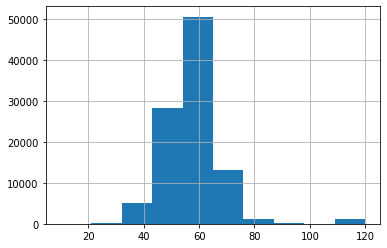

In [27]:
#before applying one hot encoding or label encoding lets do some EDA
#age distribution
df.Age.hist()

In [28]:
#lets use some beutiful visualisation libraries i.e. matplotlib and seaborn
from matplotlib.pylab import plt
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")

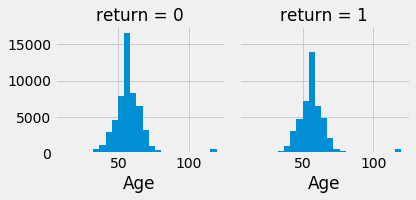

In [29]:
sns.FacetGrid(df, col="return").map(plt.hist, "Age", bins=25)

C:\Users\muskan\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


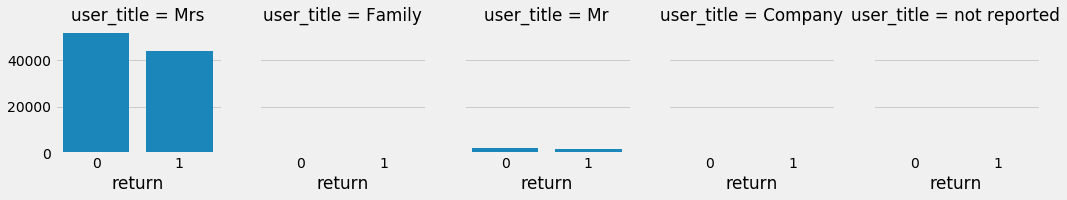

In [30]:
#gender frequrncy
g = sns.FacetGrid(df, col="user_title")
g.map(sns.countplot, "return")

In [31]:
#we can see from above user_title has a strong relationship

C:\Users\muskan\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


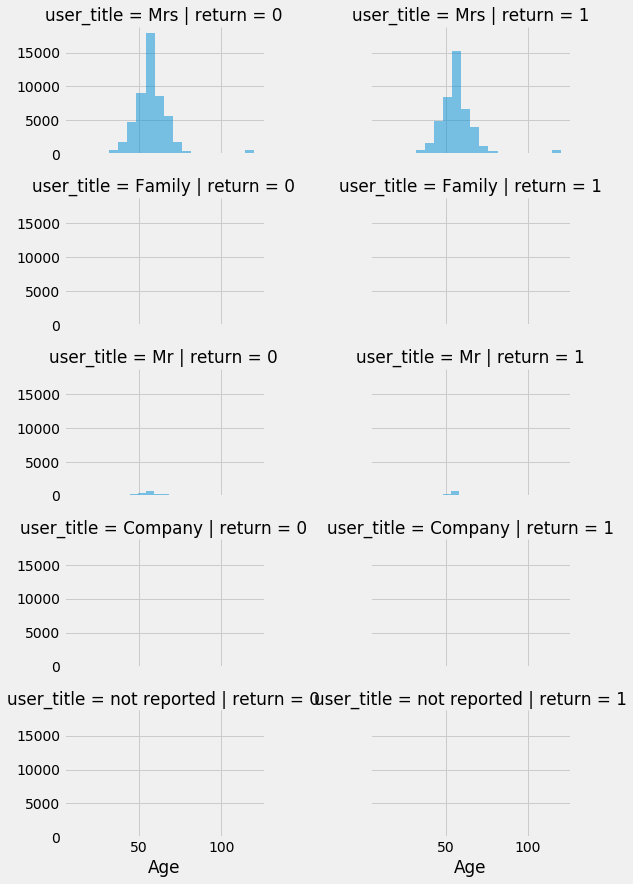

In [32]:
grid = sns.FacetGrid(df, col='return', row='user_title', size=2.5, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [33]:
#we can clearly see customer at the mid age shop more

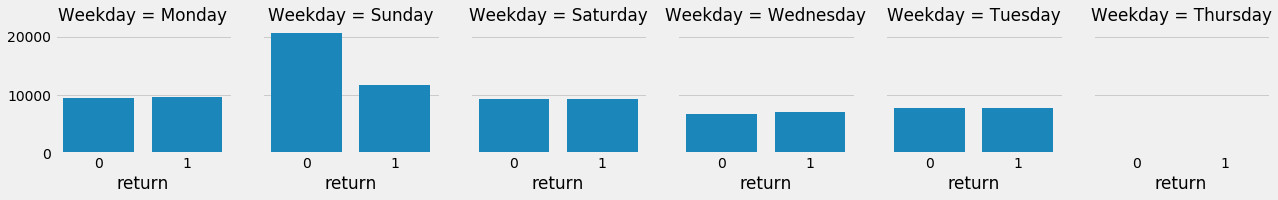

In [34]:
#output by weekday
g = sns.FacetGrid(df, col="Weekday")
g.map(sns.countplot, "return")

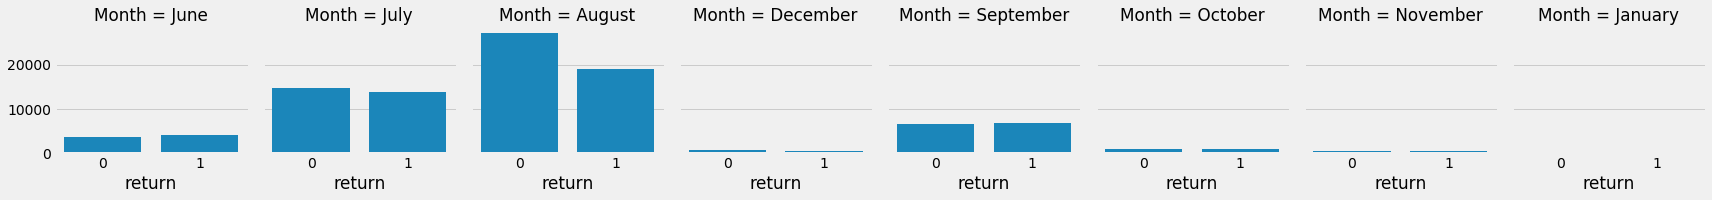

In [35]:
#output by Month
g = sns.FacetGrid(df, col="Month")
g.map(sns.countplot, "return")

**we will use label encoding to convert categorical features to numerical as one hot encoding will increase lot of columns because of high number of unique labels for some features **


In [38]:
#user_title
le = preprocessing.LabelEncoder()
print ("Before Encoding: ",df['user_title'].unique())

#encoding user_title to numerical values
df['user_title'] = le.fit_transform(df.user_title.values)

print ("After Encoding:  ",df['user_title'].unique())

Before Encoding:  ['Mrs' 'Family' 'Mr' 'Company' 'not reported']
After Encoding:   [3 1 2 0 4]


In [39]:
#its better to define own encoding for weekday and Month as we might see those months/weekdays later in the data
def month_encode(x):
    return strptime(x,'%B').tm_mon

df['Month']=df.Month.apply(month_encode)
df['Month'].value_counts()

8     46162
7     28492
9     13357
6      7753
10     2053
12     1153
11     1027
1         3
Name: Month, dtype: int64

In [40]:
def weekday_encode(x):
    return strptime(x,'%A').tm_wday
df['Weekday']=df.Weekday.apply(weekday_encode)
df['Weekday'].value_counts()

6    32346
0    19079
5    18743
1    15507
2    13929
3      396
Name: Weekday, dtype: int64

In [41]:
df['item_size'].value_counts()

l       12347
xl      10979
m       10190
xxl      8966
40       7693
        ...  
3834        1
49          1
12+         1
105         1
4034        1
Name: item_size, Length: 102, dtype: int64

In [42]:
#item_size is in both numerical as well as categorical and we have no mapping
#we can see quantile of numerical values and assign these sizes those appropriate quanitles
def item_map(x):
    #removing + sign from sizes
    x=x.replace("+","")
    
    #if size is categorical replace it with nan
    if x.isnumeric()==False:  
        x=np.nan
    return float(x)
df['item_size_numerical']=df.item_size.apply(item_map)
df.item_size_numerical.quantile([0.02,0.08,.12, .3,.6, .8,0.98])

0.02     6.0
0.08    10.0
0.12    29.0
0.30    38.0
0.60    40.0
0.80    42.0
0.98    48.0
Name: item_size_numerical, dtype: float64

In [43]:
#As we have 6 quantiles and we know how xl,l,s relate to each other we can assign each category to a quanatile
def item_map_category(x):
    x=x.replace("+","")
    if x.isnumeric()==False:  
        if x=='xxxl':
            x=48
        elif x=='xxl':
            x=42
        elif x=='xl':
            x=40
        elif x=='l':
            x=38
        elif x=='m':
            x=29
        elif x=='s':
            x=10
        elif x=='xs':
            x=6
        else: #for non-reported size we choosing mid value
            x=40
    return int(x)
df['item_size_fixed']=df.item_size.apply(item_map_category)
df.item_size_fixed.value_counts()

40      24082
38      18118
42      14058
29      10337
39       6747
        ...  
49          1
84          1
105         1
3834        1
3132        1
Name: item_size_fixed, Length: 72, dtype: int64

In [44]:
df.drop(['item_color','user_state','item_size','item_size_numerical','order_item_id','user_id'], axis=1,inplace=True)

In [45]:
#getting total columns
cols=df.columns
print("Total Columns in dataset are: ",list(cols))

#getting only numerical columns
numerical_cols=df._get_numeric_data().columns
print("Numerical Columns in dataset are: ",list(numerical_cols))

#getting categorical columns by substracting numerical columns from total columns
categorical_cols=set(list(cols))-set(list(numerical_cols))
print("Categorical Columns in dataset are: ",list(categorical_cols))

Total Columns in dataset are:  ['item_id', 'brand_id', 'item_price', 'user_title', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_reg_days', 'item_size_fixed']
Numerical Columns in dataset are:  ['item_id', 'brand_id', 'item_price', 'user_title', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_reg_days', 'item_size_fixed']
Categorical Columns in dataset are:  []


In [46]:
df.head()

,item_id,brand_id,item_price,user_title,return,Age,Delivery_time,Weekday,Month,user_reg_days,item_size_fixed
2,270,49,79.9,3,1,51.0,5.0,0,6,2374,42
4,561,3,14.9,3,1,51.0,5.0,0,6,2374,42
5,579,3,19.9,3,1,51.0,5.0,0,6,2374,42
7,106,6,39.9,3,1,51.0,5.0,0,6,2374,50
8,195,46,13.9,3,1,51.0,5.0,0,6,2374,42


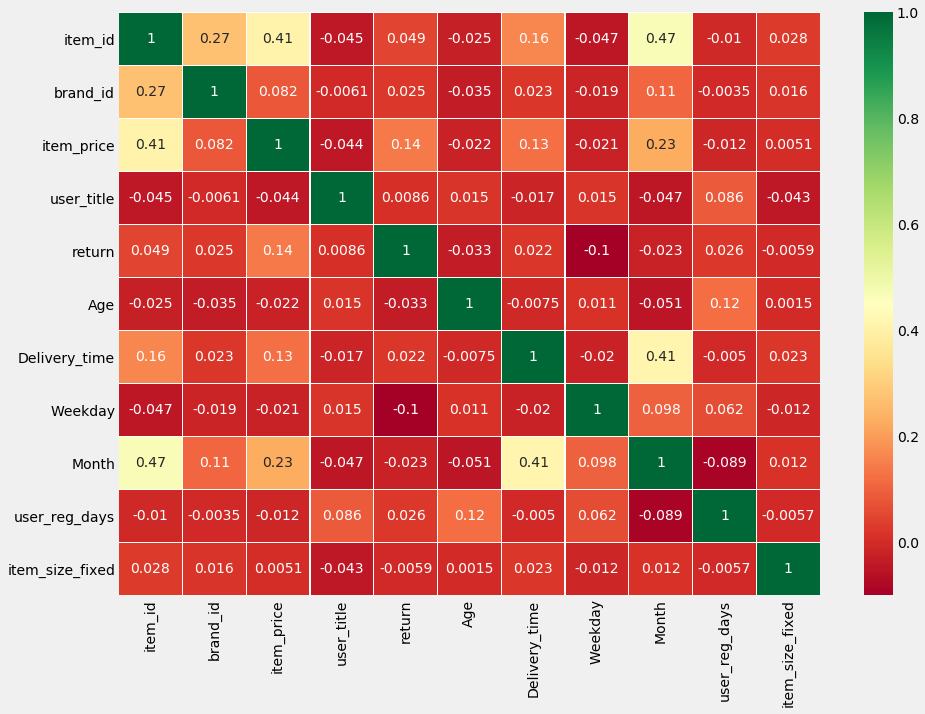

In [47]:
#correlation matrix
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':14})
fig=plt.gcf()
fig.set_size_inches(14,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [48]:
#item_price has the highest correlation

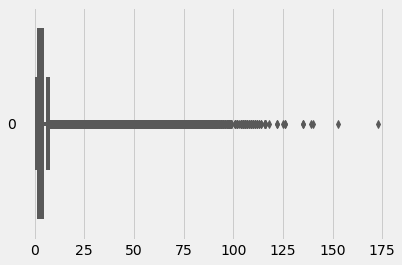

In [51]:
#check for outlier
ax = sns.boxplot(data=df['Delivery_time'], orient="h", palette="Set2")

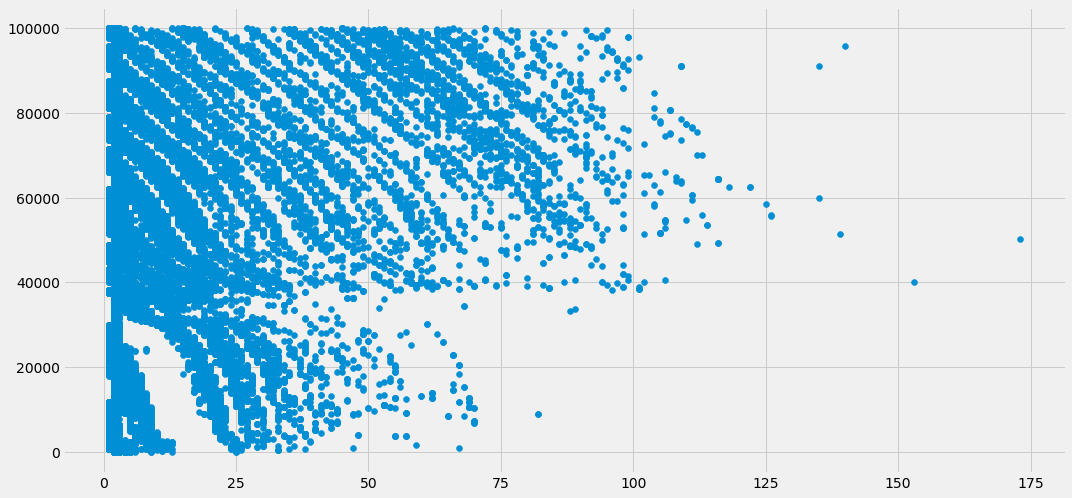

In [55]:
#delivery_time
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['Delivery_time'], df.index)

In [56]:
#there are few outliers which can be ignored since we can make models which are robust to outliers

In [59]:
#train and test split
x = df.drop(['return'],axis=1) #training features
y = df['return'] # target variable
X_train, X_test1, y_train, y_test= train_test_split(x, y, test_size=0.20, random_state=42)

#converting to numpy array
X_train= np.array(X_train)
y_train = np.array(y_train)
X_test1 = np.array(X_test1)
y_test = np.array(y_test)

In [60]:
#normalizing features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test1)

In [74]:
#using Random Forest
clf =RandomForestClassifier(random_state=1,n_estimators=200,class_weight='balanced',
                    min_samples_leaf=5,
                       min_samples_split=10)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) 

In [75]:
print("Accuracy on test  is:",accuracy_score(y_test,y_pred))

Accuracy on test  is: 0.67695


In [76]:
cm = confusion_matrix(y_test, y_pred)
  
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[6748 4050]
 [2411 6791]]


In [77]:
#using Logistic regression
clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test  is:",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
  
print ("Confusion Matrix : \n", cm)

Accuracy on test  is: 0.58515
Confusion Matrix : 
 [[8256 2542]
 [5755 3447]]


In [65]:
#using xgboost
## Hyper Parameter Optimization
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

from sklearn.model_selection import GridSearchCV, GridSearchCV, RandomizedSearchCV
import xgboost


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)


In [66]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x,y)
timer(start_time) # timing eX_trainds here for "start_y_traintime" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.1min finished
C:\Users\muskan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 12.16 seconds.


**after hyperparameter tuning lets see which are our best parameters and then will pass it to get the final output**

In [68]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [69]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [70]:
from sklearn.model_selection import cross_val_score

score=cross_val_score(classifier,X_train,y_train,cv=10)

C:\Users\muskan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [78]:
score

array([0.6795  , 0.678   , 0.673375, 0.689375, 0.67175 , 0.672875,
       0.674875, 0.668   , 0.675875, 0.672375])

In [72]:
score.mean()

0.6756